In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from iprocessor import add_day_name_column,smooth_sundays_rolling_w7_l,add_date_name_column
#from numerical_simulation import param_dict_r as param_dict,t_fit


In [2]:
#---------------------------------------------
df = pd.read_csv(r'German_case_period_may_aug.csv')

# -------------------------------------------------------------------------------Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# ------------------------------------------------------------------------------  Modification
# Add the 'days' column
df = add_day_name_column(df)
df = add_date_name_column(df)
print(df['n_recovered'])
# ----------------------------------------------------------------------------- second modification with w7_l
df_observed = smooth_sundays_rolling_w7_l(df)

0       0
1     668
2     569
3     789
4     858
     ... 
88    731
89    770
90    749
91    829
92    697
Name: n_recovered, Length: 93, dtype: int64


In [3]:
def derivative_rhs( t,x):
    S, E, A, I, F, R, D = x
    derivS = - contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population
    derivE = contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population - E / exposed_period
    derivA = prob_asymptomatic * E / exposed_period - A / asymptomatic_period
    derivI = (
                         1 - prob_asymptomatic) * E / exposed_period + dev_symp * A / asymptomatic_period - I / infectious_period  # +
    derivF = prob_quarant_inf * I / infectious_period - F / isolated_period + test_asy * A / asymptomatic_period  # prob_isolated_asy*A/asymptomatic_period
    derivR = (1 - prob_quarant_inf - mortality_infected) * I / infectious_period + (
                1 - mortality_isolated) * F / isolated_period + (
                         1 - dev_symp - test_asy) * A / asymptomatic_period  # (1-prob_isolated_asy)*A / asymptomatic_period
    derivD = (mortality_infected) * I / infectious_period + mortality_isolated * F / isolated_period
    return np.array([derivS, derivE, derivA, derivI, derivF, derivR, derivD])

In [4]:
# 2020.05.20 initialization

total_population = 82_000_000  # Total number of individuals
E0 = 2026.25
A0 = 3798
I0 = 376.4
F0 = 2255
R0 = 170204
D0 = 9060
S0 = total_population - E0 - A0 - I0 - F0 - R0 - D0
initial_conditions = [S0, E0, A0, I0, F0, R0, D0]

In [5]:
'''
@param transmission_prob Transmission probability.
@param reducing_transmission factor that reduce the transmission of asymptomatic ~ 0.859
@param total_population Total number of individuals.
@param exposed_period Mean exposed period.
@param asymptomatic_period Mean asymptomatic infectious period.
@param infectious_period Mean infectious period.
@param isolated_period Mean quarantined period.
@param prob_asymptomatic Probability of being asymptomatic once exposed.
@param prob_isolated Probability of being isolated once infected.
@param prob_dead Probability of dying
@dev_symp proportion for asymptomatic to develop symptoms and goes to symptomatic compartment
@param test_asy proportion that Asymptomatic individuals gets tested and found positive to be isolated
@param mortality_isolated the rate of COVID-19 mortality for individuals in the quarantined compartment'''
# ------------------------------------------------------replacing values
contacts = 0.9737  # where we need to estimate the value by fitting
transmission_prob = 0.3154  # 0.3649
total_population = 82000000
reducing_transmission = 0.55  # 0.764
exposed_period = 5.2  #
asymptomatic_period = 7
infectious_period = 3.7
isolated_period = 12  # 11  # 11,23
prob_asymptomatic = 0.34  # 0.2
prob_quarant_inf = 0.9303  # 0.05
test_asy = 0.271  # 0.171
dev_symp = 0.125
mortality_isolated = 0.02
mortality_infected = 0.1


In [6]:
#tmax = t_fit  # maximum simulation day
tmax = 90#269
fslarge = 20
fssmall = 16


t_fit = df_observed['days'].max()
# Plot simulation results
t = np.linspace(0, t_fit, (t_fit +1) * 10)




def seaifrd_model(x, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                  exposed_period, asymptomatic_period, infectious_period, isolated_period,
                  prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected):
    def derivative(x, initial_conditions):
        return derivative_rhs(x, initial_conditions, contacts, transmission_prob, total_population,
                              reducing_transmission,
                              exposed_period, asymptomatic_period, infectious_period,
                              isolated_period, prob_asymptomatic,
                              prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)

    solution = integrate.solve_ivp(derivative_rhs,(0,t_fit+1), y0=initial_conditions, t_eval=t)
    #print(solution)
    return solution  # .y.flatten()

t  (940,), result_list (5, 940)


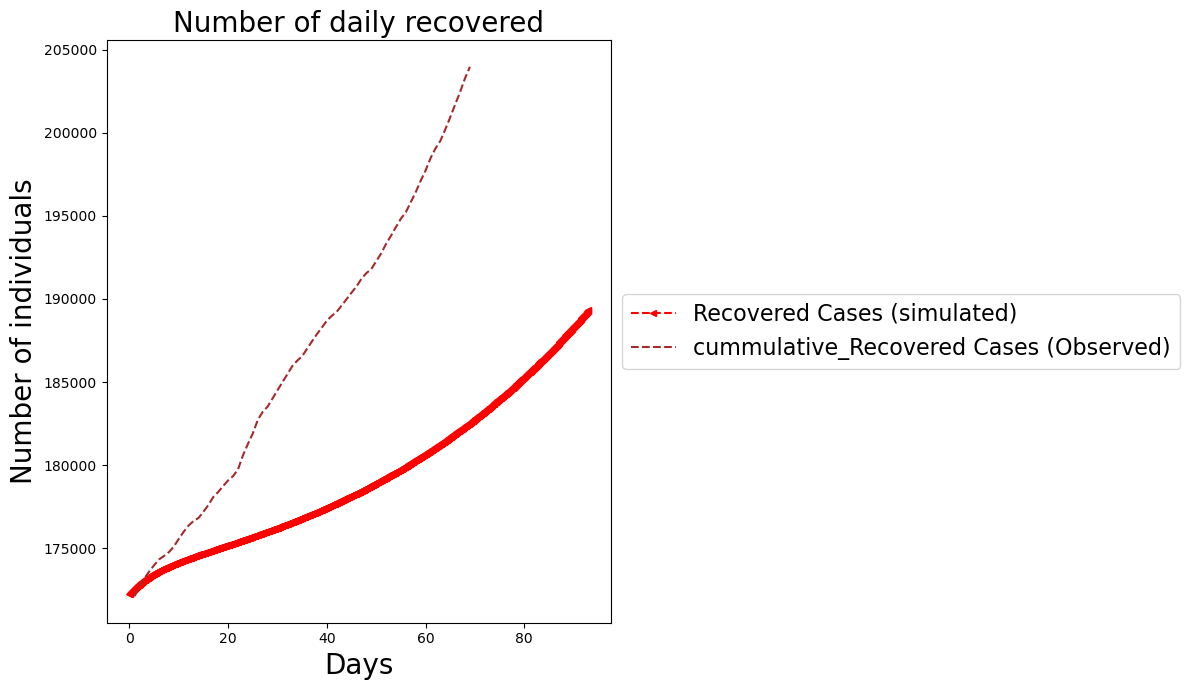

In [38]:

#  simulated data
solution = seaifrd_model(t, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                             exposed_period, asymptomatic_period, infectious_period, isolated_period,
                             prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)

#result_list = np.diff(solution_seaifrd[:, 6])#--------------------------------------applying numpy for the difference
R_value = solution.y[:5]
times = solution.t

#print(R_value)





#t = t[:-1]#------------------------reducing last row, as my result_list is one row shorter
print(f't  {t.shape}, result_list {R_value.shape}')
fig, ax = plt.subplots(figsize=[12, 7])
ax.plot(times, R_value[1]+R0, label='Recovered Cases (simulated)', linestyle='--', marker='<', color='red', markersize=4)
#print(f'simulated ,{solution_seaifrd[:, 5]}')
#storing_list = solution_seaifrd[:, 5]
#print(storing_list)

# Overlay the graph of observed confirmed cases
#ax.plot(df['n_recovered'],  label='daily_Recovered Cases (Observed)', linestyle='-', color='blue')
ax.plot(range(1,70),list(df['Recovered'])[24:],  label='cummulative_Recovered Cases (Observed)', linestyle='--', color='brown')
# title
ax.set_xlabel('Days', fontsize=fslarge)
ax.set_ylabel('Number of individuals', fontsize=fslarge)
ax.set_title('Number of daily recovered', fontsize=fslarge)

#  legend
ax.legend(fontsize=fssmall, loc='center left', bbox_to_anchor=(1, 0.5))

#  layout
plt.tight_layout()

# Show the plot
plt.show()


In [32]:
times

array([ 0.        ,  0.09904153,  0.19808307,  0.2971246 ,  0.39616613,
        0.49520767,  0.5942492 ,  0.69329073,  0.79233227,  0.8913738 ,
        0.99041534,  1.08945687,  1.1884984 ,  1.28753994,  1.38658147,
        1.485623  ,  1.58466454,  1.68370607,  1.7827476 ,  1.88178914,
        1.98083067,  2.0798722 ,  2.17891374,  2.27795527,  2.37699681,
        2.47603834,  2.57507987,  2.67412141,  2.77316294,  2.87220447,
        2.97124601,  3.07028754,  3.16932907,  3.26837061,  3.36741214,
        3.46645367,  3.56549521,  3.66453674,  3.76357827,  3.86261981,
        3.96166134,  4.06070288,  4.15974441,  4.25878594,  4.35782748,
        4.45686901,  4.55591054,  4.65495208,  4.75399361,  4.85303514,
        4.95207668,  5.05111821,  5.15015974,  5.24920128,  5.34824281,
        5.44728435,  5.54632588,  5.64536741,  5.74440895,  5.84345048,
        5.94249201,  6.04153355,  6.14057508,  6.23961661,  6.33865815,
        6.43769968,  6.53674121,  6.63578275,  6.73482428,  6.83

In [8]:
# visualization for all the y[*] SEAIFRD
y_0 = solution.y[0]
y1 = solution.y[1]
y2 = solution.y[2]
y3 = solution.y[3]
y4 = solution.y[4]
y5 = solution.y[5]
y6 = solution.y[6]

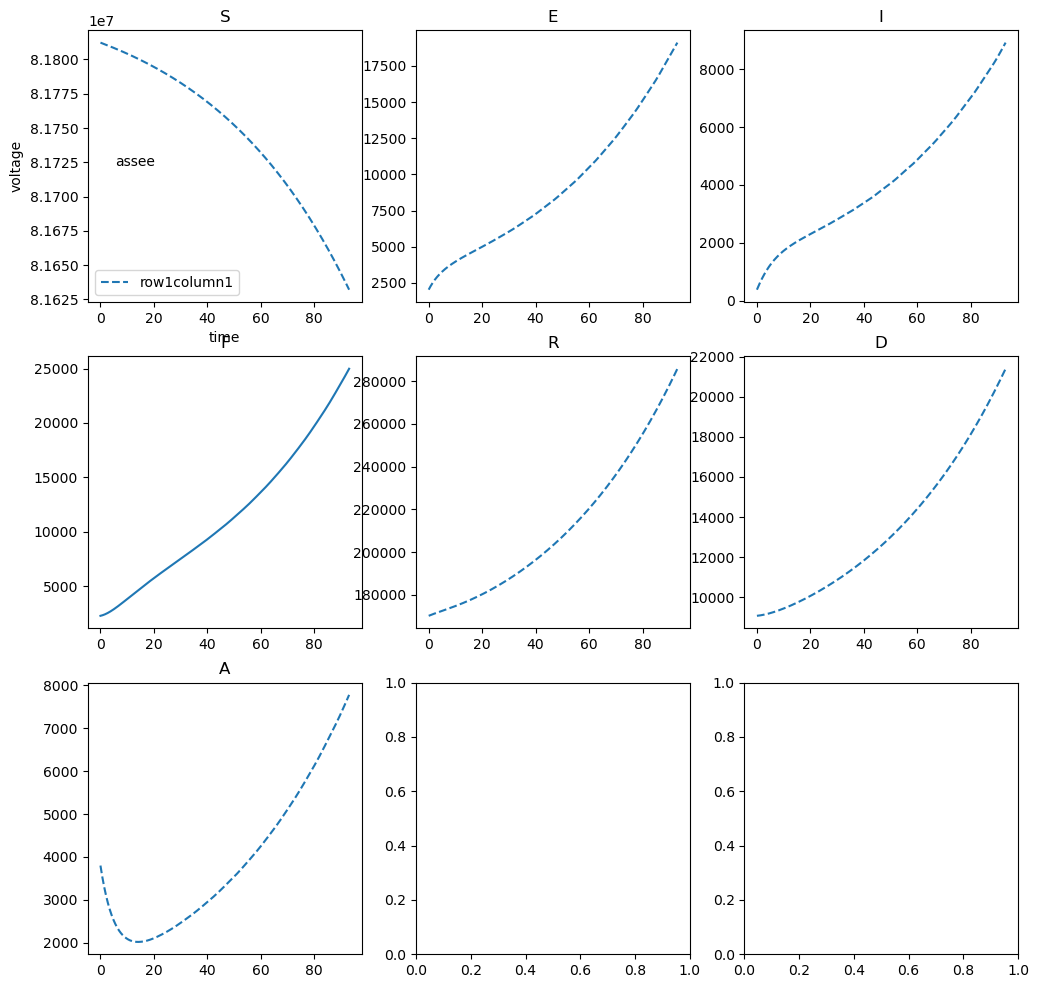

In [9]:
fig, axes = plt.subplots(3,3, figsize=(12,12))

ax = axes[0][0]
ax.plot(times,y_0,'--',label='row1column1')
ax.set_xlabel('time')
ax.set_ylabel('voltage')
ax.text(0.1,0.5,'assee',transform=ax.transAxes)# putting in text
ax.tick_params(axis='both',labelsize=10)# messing with size of tick
ax.legend(loc='lower left', fontsize=10, frameon=True)
ax.set_title('S')
#
ax = axes[0][1]
ax.plot(times,y1,'--',label='row2column1')
ax.set_title('E')
             
ax = axes[2][0]
ax.plot(times,y2,'--',label='row2column1')
ax.set_title('A')
#
ax = axes[0][2]
ax.plot(times,y3,'--',label='row1column2')
ax.set_title('I')
#
ax = axes[1][0]
ax.plot(times,y4,'-',label='row2column2')
ax.set_title('F')
#
ax = axes[1][1]
ax.plot(times,y5,'--',label='row2column1')
ax.set_title('R')
#
ax = axes[1][2]
ax.plot(times,y6,'--',label='row2column1')
ax.set_title('D')
#


plt.show()

